In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plutonite","key":"d09354b4fd3e9ebfd7ddf0f07b6ec02f"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c bcse-332-l-mock-fatlab-fall-2024

 92% 201M/218M [00:01<00:00, 128MB/s]
100% 218M/218M [00:01<00:00, 119MB/s]


In [7]:
!unzip bcse-332-l-mock-fatlab-fall-2024.zip

Streaming output truncated to the last 5000 lines.
  inflating: new_dataset/train/cats/cat.3704.jpg  
  inflating: new_dataset/train/cats/cat.3705.jpg  
  inflating: new_dataset/train/cats/cat.3706.jpg  
  inflating: new_dataset/train/cats/cat.3707.jpg  
  inflating: new_dataset/train/cats/cat.3708.jpg  
  inflating: new_dataset/train/cats/cat.3709.jpg  
  inflating: new_dataset/train/cats/cat.371.jpg  
  inflating: new_dataset/train/cats/cat.3710.jpg  
  inflating: new_dataset/train/cats/cat.3711.jpg  
  inflating: new_dataset/train/cats/cat.3712.jpg  
  inflating: new_dataset/train/cats/cat.3713.jpg  
  inflating: new_dataset/train/cats/cat.3714.jpg  
  inflating: new_dataset/train/cats/cat.3715.jpg  
  inflating: new_dataset/train/cats/cat.3716.jpg  
  inflating: new_dataset/train/cats/cat.3717.jpg  
  inflating: new_dataset/train/cats/cat.3718.jpg  
  inflating: new_dataset/train/cats/cat.3719.jpg  
  inflating: new_dataset/train/cats/cat.372.jpg  
  inflating: new_dataset/train/ca

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import pandas as pd
import os
import numpy as np

In [9]:
# Constants
IMG_SIZE = 224  # ResNet50 expected input size
BATCH_SIZE = 32
EPOCHS = 10

# Set up data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    '/content/new_dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/new_dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [13]:
# Create the model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 124s 541ms/step - accuracy: 0.5064 - loss: 0.8045 - val_accuracy: 0.6040 - val_loss: 0.6686
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 102s 498ms/step - accuracy: 0.5429 - loss: 0.6996 - val_accuracy: 0.6009 - val_loss: 0.6618
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 102s 495ms/step - accuracy: 0.5734 - loss: 0.6778 - val_accuracy: 0.6071 - val_loss: 0.6627
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 100s 487ms/step - accuracy: 0.5963 - loss: 0.6725 - val_accuracy: 0.6221 - val_loss: 0.6569
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 142s 485ms/step - accuracy: 0.6056 - loss: 0.6651 - val_accuracy: 0.6109 - val_loss: 0.6559
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 140s 477ms/step - accuracy: 0.5876 - loss: 0.6731 - val_accuracy: 0.6184 - val_loss: 0.6605
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 144s 485ms/step - accuracy: 0.5969 - loss: 0.6664 - val_accuracy: 0.6271 - val_loss: 0.6551
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 143s 490ms/step - accuracy: 0.5907 - loss: 0.67

In [16]:
# Fine-tuning phase
# Unfreeze some layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
# Continue training
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 134s 562ms/step - accuracy: 0.5818 - loss: 0.7289 - val_accuracy: 0.6265 - val_loss: 0.6535
Epoch 2/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 120s 493ms/step - accuracy: 0.6631 - loss: 0.6138 - val_accuracy: 0.6508 - val_loss: 0.6264
Epoch 3/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 143s 502ms/step - accuracy: 0.6716 - loss: 0.6006 - val_accuracy: 0.5815 - val_loss: 0.6790
Epoch 4/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 141s 495ms/step - accuracy: 0.6970 - loss: 0.5831 - val_accuracy: 0.7189 - val_loss: 0.5678
Epoch 5/5
201/201 ━━━━━━━━━━━━━━━━━━━━ 142s 495ms/step - accuracy: 0.6922 - loss: 0.5789 - val_accuracy: 0.6009 - val_loss: 0.7351


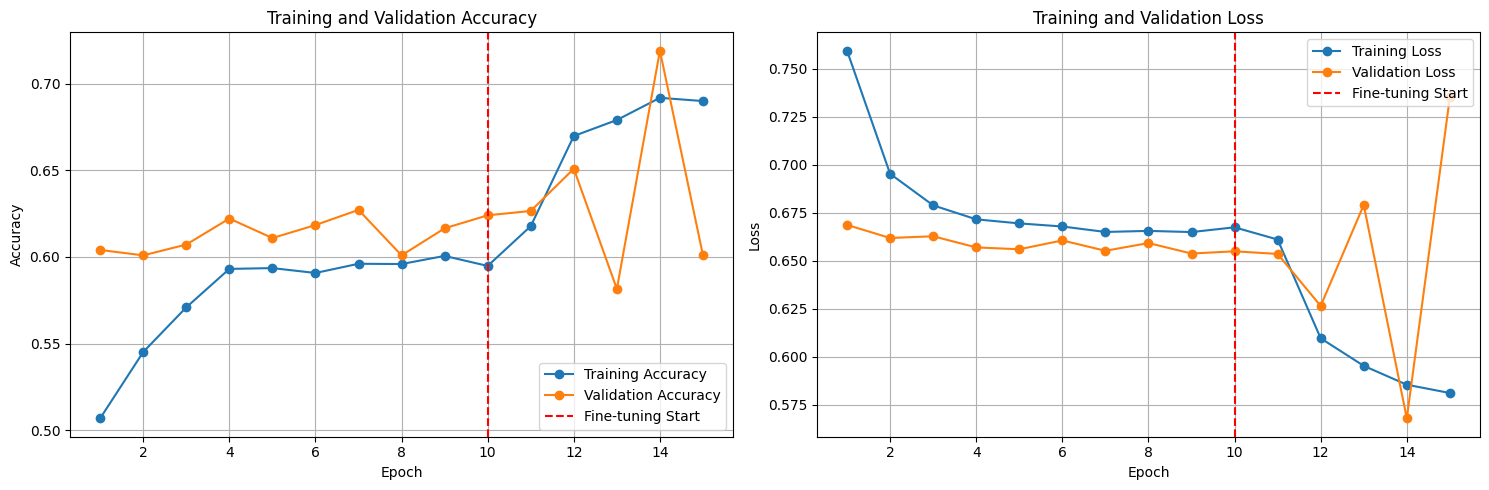

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history, history_fine):
    # Combine histories
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    # Find transition epoch
    transition_epoch = len(history.history['accuracy'])
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.axvline(x=transition_epoch, color='r', linestyle='--', label='Fine-tuning Start')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.axvline(x=transition_epoch, color='r', linestyle='--', label='Fine-tuning Start')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print(f"Training Accuracy: {acc[-1]:.4f}")
    print(f"Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Training Loss: {loss[-1]:.4f}")
    print(f"Validation Loss: {val_loss[-1]:.4f}")

# Call this function after training
plot_training_history(history, history_fine)

In [1]:
!pip install opencv-python

import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2


IMG_SIZE = 300  # Use the same size you used during training
BATCH_SIZE = 1  # Keep this as 1 for accurate file mapping
test_dir = '/content/new_dataset/test' # Path to your test directory

# Get a list of all image filenames in the test directory
filenames = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]

# Create a DataFrame with filenames
df_test = pd.DataFrame({'filename': filenames})

# Function to load and preprocess images
def load_and_preprocess(img_path):
  img = cv2.imread(os.path.join(test_dir, img_path))
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  img = img / 255.0  # Rescale to [0, 1]
  return img

# Apply the function to the 'filename' column
df_test['image'] = df_test['filename'].apply(load_and_preprocess)

# Convert the 'image' column to a NumPy array
test_images = np.stack(df_test['image'].values)

# Number of test time augmentations (set to 1 if you don't want TTA)
n_augmentations = 3

# Initialize array for predictions
predictions = np.zeros((len(filenames), 1))

# Make predictions with test-time augmentation
print("Making predictions...")
for i in range(n_augmentations):
  temp_preds = model.predict(test_images, verbose=1)
  predictions += temp_preds

predictions /= n_augmentations  # Average the predictions

# Create submission DataFrame
submission = pd.DataFrame({
    'id': [os.path.basename(filename) for filename in filenames],
    'label': (predictions > 0.5).astype(int).flatten()
})

# Sort by id to ensure consistent order
submission = submission.sort_values(by='id')

# Save submission file
submission.to_csv('submission.csv', index=False)

# Print some information to verify the submission
print("\nSubmission file created!")
print(f"Total predictions: {len(submission)}")
print("\nFirst few predictions:")
print(submission.head())
print("\nValue counts (0=cat, 1=dog):")
print(submission['label'].value_counts())

Making predictions...


NameError: name 'model' is not defined